In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('../data/raw/MachineLearningRating_v3.txt', sep='|', low_memory=False)

# Clean numeric columns
data['TotalClaims'] = pd.to_numeric(data['TotalClaims'], errors='coerce')
data['TotalPremium'] = pd.to_numeric(data['TotalPremium'], errors='coerce')

# Avoid division by zero or invalid values
data = data.replace([np.inf, -np.inf], np.nan)

# Create LossRatio
data['LossRatio'] = data['TotalClaims'] / data['TotalPremium']
data['LossRatio'] = data['LossRatio'].replace([np.inf, -np.inf], np.nan)

# Filter valid rows
data = data.dropna(subset=['LossRatio', 'Province', 'Gender'])
data = data[data['TotalPremium'] > 0]
data = data[data['Gender'].isin(['Male', 'Female'])]




# === ANOVA: Risk differences across Provinces ===
anova_groups = [group['LossRatio'].values for _, group in data.groupby('Province')]
f_stat, p_val_anova = stats.f_oneway(*anova_groups)

print("\n📊 ANOVA: LossRatio by Province")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val_anova:.4f}")
if p_val_anova < 0.05:
    print("✅ Reject H₀: Significant risk difference across provinces.")
else:
    print("❌ Fail to reject H₀: No significant risk difference across provinces.")

# === T-test: Risk differences between Genders ===
male_loss = data[data['Gender'] == 'Male']['LossRatio']
female_loss = data[data['Gender'] == 'Female']['LossRatio']
t_stat, p_val_ttest = stats.ttest_ind(male_loss, female_loss, equal_var=False)

print("\n📊 T-test: LossRatio by Gender")
print(f"T-statistic: {t_stat:.4f}, p-value: {p_val_ttest:.4f}")
if p_val_ttest < 0.05:
    print("✅ Reject H₀: Significant risk difference between genders.")
else:
    print("❌ Fail to reject H₀: No significant risk difference between genders.")


    # Calculate margin
data['Margin'] = data['TotalPremium'] - data['TotalClaims']

# Remove NaN/inf margin values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=['Margin', 'PostalCode'])

# Focus on top 10 most frequent postal codes to ensure sample size
top_zipcodes = data['PostalCode'].value_counts().head(10).index
filtered_zip = data[data['PostalCode'].isin(top_zipcodes)]

# ANOVA for margin differences by PostalCode
zip_groups = [group['Margin'].values for _, group in filtered_zip.groupby('PostalCode')]
f_stat, p_val_zip = stats.f_oneway(*zip_groups)

print("\n📊 ANOVA: Margin by Postal Code")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val_zip:.4f}")
if p_val_zip < 0.05:
    print("✅ Reject H₀: Significant margin difference across Zip Codes.")
else:
    print("❌ Fail to reject H₀: No significant margin difference across Zip Codes.")





📊 ANOVA: LossRatio by Province
F-statistic: 1.9746, p-value: 0.0655
❌ Fail to reject H₀: No significant risk difference across provinces.

📊 T-test: LossRatio by Gender
T-statistic: -0.5798, p-value: 0.5621
❌ Fail to reject H₀: No significant risk difference between genders.

📊 ANOVA: Margin by Postal Code
F-statistic: 1.8533, p-value: 0.0541
❌ Fail to reject H₀: No significant margin difference across Zip Codes.


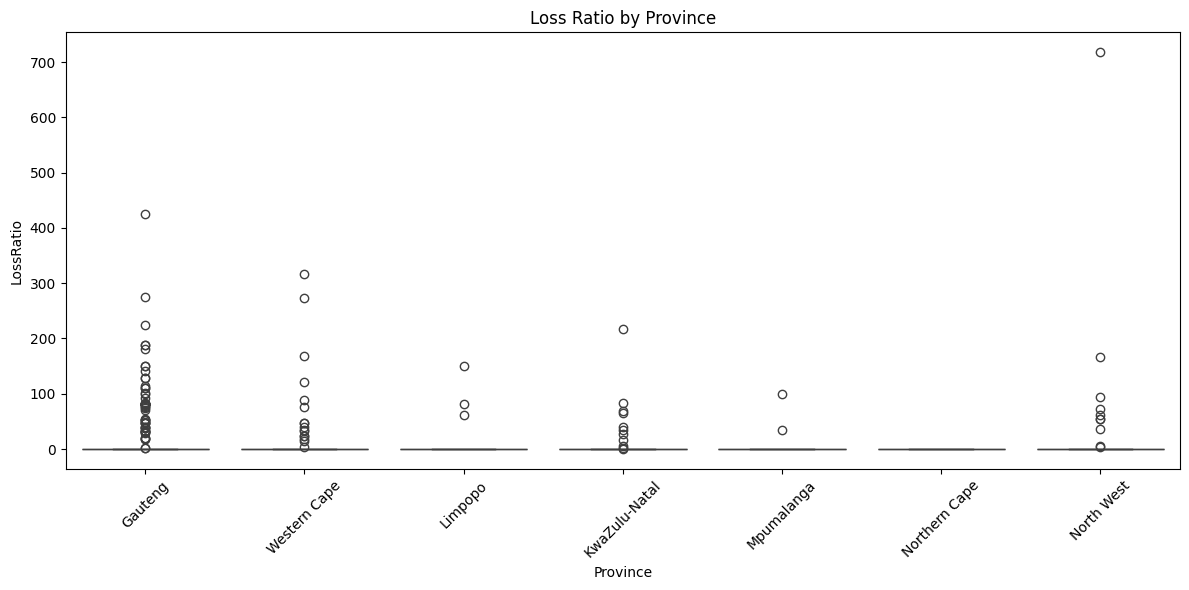

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x='Province', y='LossRatio', data=data)
plt.title('Loss Ratio by Province')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


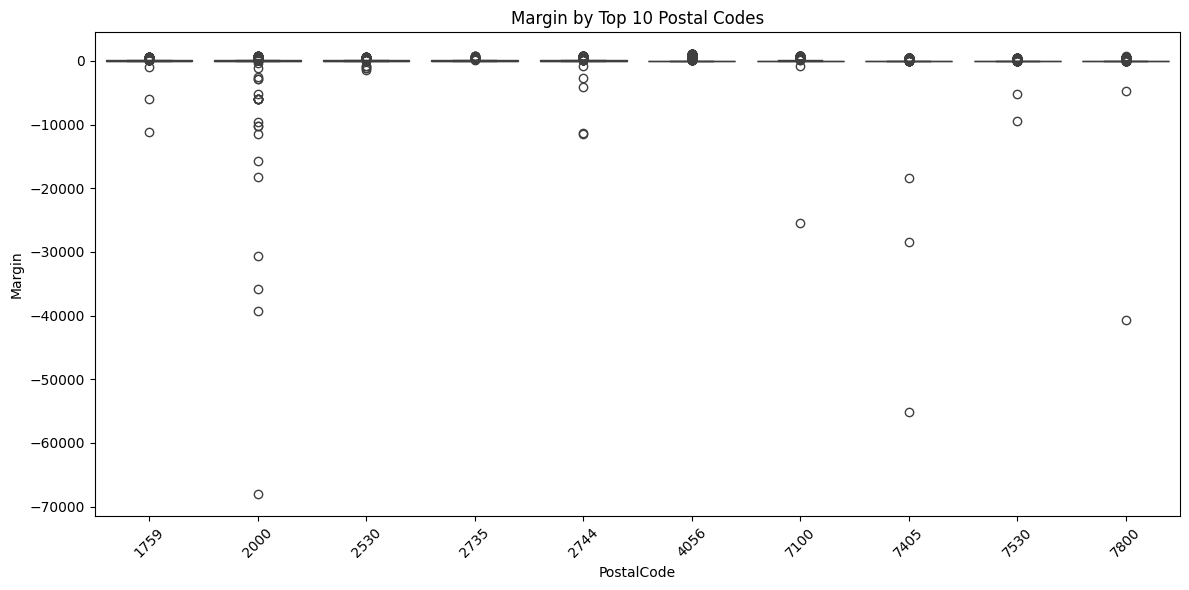

In [3]:
plt.figure(figsize=(12,6))
sns.boxplot(x='PostalCode', y='Margin', data=filtered_zip)
plt.title('Margin by Top 10 Postal Codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
